Bibliotecas

In [195]:
# Downloads e comentários para instalação
# %pip install pandas wordcloud matplotlib numpy scikit-learn nltk beautifulsoup4 seaborn textblob vaderSentiment stanza symspellpy tokenizers transformers contractions
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('brown')
# stanza.download('en')
#%pip install langdetect
#%pip install googletrans==4.0.0rc1
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Processamento de texto e NLP
import re
import string
import contractions
from collections import Counter
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords, sentiwordnet as swn, wordnet as wn
from nltk.tokenize import (
    TweetTokenizer, word_tokenize, sent_tokenize, RegexpTokenizer
)
from nltk import pos_tag
from textblob import TextBlob

import spacy
from symspellpy import SymSpell, Verbosity
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from transformers import BertTokenizer


# Outros
import gzip
import math
from googletrans import Translator
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from tqdm import tqdm

# Inicialização de modelos externos
nlp = spacy.load("en_core_web_sm")




# Análise Exploratória de Dados

Importação
Visualização
Estrutura
Omissos
Duplicados

In [196]:
#Upload dos datasets
train_df = pd.read_csv("amazon_reviews_train.csv", encoding = "utf-8")
test_df = pd.read_csv("amazon_reviews_test.csv", encoding = "utf-8")

# Informações gerais
print("Treino:", train_df.shape, " | Colunas:", list(train_df.columns))
print("Teste :", test_df.shape, " | Colunas:", list(test_df.columns))

# Visualizar primeiras e últimas linhas
print("\n Head Treino:\n", train_df.head(3))
print("\n Tail Treino:\n", train_df.tail(3))
print("\n Head Teste:\n", test_df.head(3))
print("\n Tail Teste:\n", test_df.tail(3))

# Info e dtypes
print("\n Info Treino:")
train_df.info()
print("\n Info Teste:")
test_df.info()

#Omissos
valores_omissos = ["", " ", "  ", "\n", ".", "na", "Na", "NA", "null", "NULL"]
print("\n Strings vazias ou inválidas:")
print("Treino:\n", train_df.isin(valores_omissos).sum())
print("Teste:\n", test_df.isin(valores_omissos).sum())
omissos_train = train_df.isnull() | train_df.isin(valores_omissos)
omissos_test = test_df.isnull() | test_df.isin(valores_omissos)
print("\n Valores omissos (NaN ou string vazia):")
print("Treino:\n", omissos_train.sum())
print("Teste:\n", omissos_test.sum())

# Valores únicos por coluna
print("\n Valores únicos por coluna:")
print("Treino:\n", train_df.nunique())
print("Teste:\n", test_df.nunique())

# Verificar duplicados
print("\n  Duplicados:")
print("Treino:", train_df.duplicated().sum())
print("Teste :", test_df.duplicated().sum())

#Review mais longa e mais curta
#Treino
review_mais_longa_train = train_df['review'].astype(str).apply(len).idxmax()
review_mais_curta_train = train_df['review'].astype(str).apply(len).idxmin()
print("\nTreino - Review mais longa:")
print(train_df.loc[review_mais_longa_train, 'review'])
print("Treino - Review mais curta:")
print(train_df.loc[review_mais_curta_train, 'review'])
#Teste
review_mais_longa_test = test_df['review'].astype(str).apply(len).idxmax()
review_mais_curta_test = test_df['review'].astype(str).apply(len).idxmin()
print("\nTeste - Review mais longa:")
print(test_df.loc[review_mais_longa_test, 'review'])
print("Teste - Review mais curta:")
print(test_df.loc[review_mais_curta_test, 'review'])

Treino: (48902, 2)  | Colunas: ['sentiment', 'review']
Teste : (2417, 2)  | Colunas: ['sentiment', 'review']

 Head Treino:
   sentiment                                             review
0  negative  Product arrived labeled as Jumbo Salted Peanut...
1  positive  This is a confection that has been around a fe...
2  negative  If you are looking for the secret ingredient i...

 Tail Treino:
       sentiment                                             review
48899  positive  My two little boys love these treats. So much ...
48900  positive  Our Shiba loves these. Over a three week perio...
48901  positive  I have 2 boxers. 1 is 16 mos. and the other is...

 Head Teste:
   sentiment                                             review
0  negative  I was going to give these seeds a 3-star ratin...
1  positive  This is a nice smooth coffee, a part of the Ke...
2  positive  I order this pearl sugar to make liege waffle....

 Tail Teste:
      sentiment                                           

Detalhes dos duplicados

In [197]:
# Contar os duplicados no treino e teste(review e sentimento). Não incluir o original na contagem
duplicados_treino = train_df.duplicated(keep='first').sum()
duplicados_teste = test_df.duplicated(keep='first').sum()

print(f"Total de duplicados no treino (linhas idênticas): {duplicados_treino}")
print(f"Total de duplicados no teste (linhas idênticas): {duplicados_teste}")


# Verificar se existe algum duplicado com sentimento diferente
sentimentos_treino = train_df.groupby('review')['sentiment'].nunique()
sentimentos_teste = test_df.groupby('review')['sentiment'].nunique()
incoerentes_treino = sentimentos_treino[sentimentos_treino > 1]
incoerentes_teste = sentimentos_teste[sentimentos_teste > 1]
print(f"\nReviews com sentimentos diferentes no treino: {len(incoerentes_treino)}")
print(f"Reviews com sentimentos diferentes no teste: {len(incoerentes_teste)}")

# Mostrar duplicados com sentimentos diferentes
# Exibir uma review específica completa
print(train_df.loc[train_df['review'] == incoerentes_treino.index[0], 'review'].values[0])

# Uniformizar sentimento (manter o primeiro)
train_df['sentiment'] = train_df.groupby('review')['sentiment'].transform('first')

# Apagar observações duplicadas do conjunto de treino
train_df_sem_duplicados = train_df.drop_duplicates()
train_df = train_df_sem_duplicados
print(f"\nNúmero de linhas após remover duplicatas no treino: {len(train_df_sem_duplicados)}")

# Guardar num csv
train_df_sem_duplicados.to_csv("train_sem_duplicados.csv", index=False)


Total de duplicados no treino (linhas idênticas): 3531
Total de duplicados no teste (linhas idênticas): 25

Reviews com sentimentos diferentes no treino: 1
Reviews com sentimentos diferentes no teste: 0
I ordered the complete set of Totonac sugar free syrups and tested them out with my morning Kellogg's Eggo waffles.<br /><br />Some of the syrups are pretty good; others are really not my thing and I threw them out. My verdict/opinion is: Almond, Maple Syrup and Vanilla are pretty good; the Raspberry is okay (if you crave some fruit taste); but I couldn't handle the taste of the Blueberry, Butter Pecan, Caramel, Hazelnut and Vanilla Cinnamon.<br /><br />The syrup is not thick like most syrups on the market; it's more runny and I find myself pouring some syrup out on to a plate and then dipping pieces of torn waffles.

Número de linhas após remover duplicatas no treino: 45370


Distribuição de reviews por sentimento

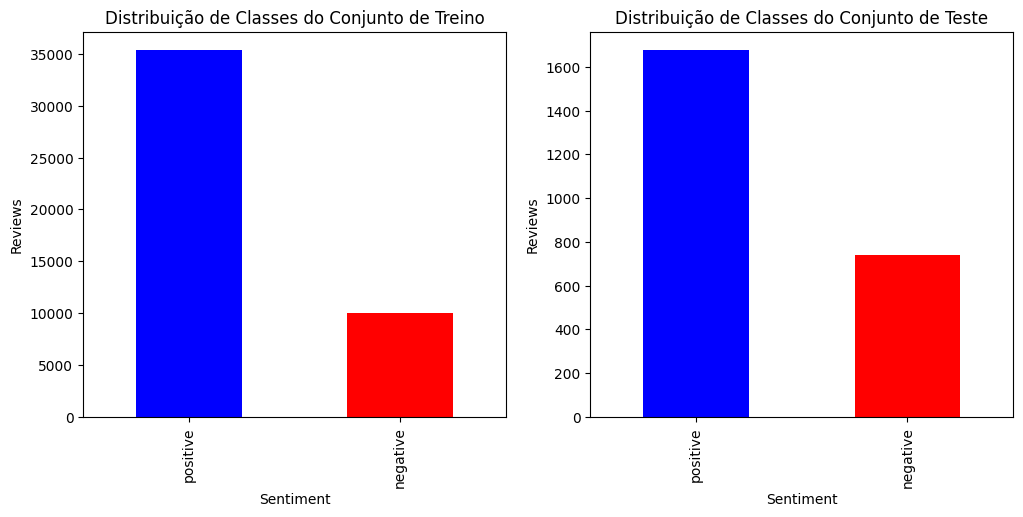


Distribuição no Treino:
 sentiment
positive    35363
negative    10007
Name: count, dtype: int64

Distribuição no Teste:
 sentiment
positive    1676
negative     741
Name: count, dtype: int64

Percentagem  de reviews por classe no Treino:
sentiment
positive    77.943575
negative    22.056425
Name: proportion, dtype: float64

Percentagem de reviews por classe no Teste:
sentiment
positive    69.34216
negative    30.65784
Name: proportion, dtype: float64


In [198]:
#Gráfico para visualizar a distribuição de classes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_df['sentiment'].value_counts().plot(kind='bar', color=['blue', 'red'], ax=axes[0])
axes[0].set_title("Distribuição de Classes do Conjunto de Treino")
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Reviews")

test_df['sentiment'].value_counts().plot(kind='bar', color=['blue', 'red'], ax=axes[1])
axes[1].set_title("Distribuição de Classes do Conjunto de Teste")
axes[1].set_xlabel("Sentiment")
axes[1].set_ylabel("Reviews")

plt.show()


# Distribuição de reviews por classe
print("\nDistribuição no Treino:\n", train_df['sentiment'].value_counts())
print("\nDistribuição no Teste:\n", test_df['sentiment'].value_counts())

# Calcular percentagem da distribuição
train_sentiment_percent = train_df['sentiment'].value_counts(normalize=True) * 100
print("\nPercentagem  de reviews por classe no Treino:")
print(train_sentiment_percent)
test_sentiment_percent = test_df['sentiment'].value_counts(normalize=True) * 100
print("\nPercentagem de reviews por classe no Teste:")
print(test_sentiment_percent)


Visualizar e contabilizar elementos possivelmente problemáticos

In [199]:
# Encontrar datas
def tem_data(texto):
    padrao_data = r'(\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b)|(\b\d{4}[/-]\d{1,2}[/-]\d{1,2}\b)'
    return bool(re.search(padrao_data, str(texto)))

# Encontrar caracteres estranhos
def tem_caracteres_estranho(texto):
    padrao_estranho = r'[^a-zA-Z0-9\s.,;:!?\'\"()\[\]-]'
    return bool(re.search(padrao_estranho, str(texto)))

# Encontrar HTML
def tem_html(texto):
    if isinstance(texto, str):
        soup = BeautifulSoup(texto, 'html.parser')
        return bool(soup.find())
    return False

def tem_nome_empresa(texto):
    padrao_empresa = r'\b(\w+\s){1,3}(Inc\.?|LLC|Ltd\.?|Co\.?|Corp\.?|S\.A\.?)\b'
    return bool(re.search(padrao_empresa, str(texto)))


# Encontrar números
def tem_numero(texto):
    return bool(re.search(r'\d', str(texto)))

# Aplicar numa cópia dos dados de treino
df = train_df.copy()

# Criar colunas booleanas para a seguir somar os valores 
df['tem_data'] = df['review'].apply(tem_data)
df['tem_numero'] = df['review'].apply(tem_numero)
df['tem_caractere_estranho'] = df['review'].apply(tem_caracteres_estranho)
df['tem_html'] = df['review'].apply(tem_html)
df['tem_nome_empresa'] = df['review'].apply(tem_nome_empresa)

# Contar quantas reviews têm cada tipo de celemento
print("\nNúmero de reviews que contêm cada tipo de elemento:")
print(df[['tem_data','tem_caractere_estranho',  'tem_html',  'tem_nome_empresa', 'tem_numero', ]].sum())



Número de reviews que contêm cada tipo de elemento:
tem_data                    130
tem_caractere_estranho    16798
tem_html                  11789
tem_nome_empresa             47
tem_numero                16086
dtype: int64


Visualizar melhor os tags html 

In [200]:
# Função para encontrar tags HTML
def encontrar_html_tags(text):
    return re.findall(r'<[^>]*>', text)

# Aplicar a função ao conjunto de treino
train_df['html_tags'] = train_df['review'].apply(encontrar_html_tags)

# Aplicar a função ao conjunto de teste
test_df['html_tags'] = test_df['review'].apply(encontrar_html_tags)

# Explorar todas as tags encontradas no conjunto de treino
train_html_tags = train_df['html_tags'].explode().value_counts()
print("Tags HTML encontradas no conjunto de treino:")
print(train_html_tags.to_string())

# Explorar todas as tags encontradas no conjunto de teste
test_html_tags = test_df['html_tags'].explode().value_counts()
print("\nTags HTML encontradas no conjunto de teste:")
print(test_html_tags.to_string())


Tags HTML encontradas no conjunto de treino:
html_tags
<br />                                                    45600
</a>                                                       1019
<span class="tiny">                                          40
</span>                                                      40
<p>                                                          17
<a href="http://www.amazon.com/gp/product/B002IEVJRY">       14
<a href="http://www.amazon.com/gp/product/B007JBO41E">        7
<a href="http://www.amazon.com/gp/product/B000DZFMEQ">        6
<a href="http://www.amazon.com/gp/product/B007RTR9FQ">        6
<a href="http://www.amazon.com/gp/product/B001AJ1ULS">        5
<a href="http://www.amazon.com/gp/product/B004M5W7YQ">        5
<a href="http://www.amazon.com/gp/product/B001LG940E">        5
<a href="http://www.amazon.com/gp/product/B001LGGH54">        4
<a href="http://www.amazon.com/gp/product/B002R81L92">        4
<a href="http://www.amazon.com/gp/product/B004391

Emoticons e emojis

In [201]:
# Função para encontrar emojis gráficos
def encontrar_emojis(texto):
    padrao_emoji = re.compile("[" 
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF" 
        u"\U0001F680-\U0001F6FF" 
        u"\U0001F700-\U0001F77F" 
        u"\U00002600-\U000026FF" 
        u"\U00002700-\U000027BF"  
        "]+", flags=re.UNICODE)
    return padrao_emoji.findall(texto)

# Função para encontrar emoticons textuais
def encontrar_emoticons(texto):
    padrao_emoticon = re.compile(r'(:\)|:\(|:D|:P|;\)|:O|:-\)|:-\(|:-D|:-P|;-D|;-P)')
    return padrao_emoticon.findall(texto)

# Função para combinar emojis gráficos e emoticons textuais
def encontrar_emojis_e_emoticons(texto):
    emojis = encontrar_emojis(texto)
    emoticons = encontrar_emoticons(texto)
    return emojis + emoticons

# Aplicar a função ao conjunto de treino
train_df['emojis_e_emoticons'] = train_df['review'].apply(encontrar_emojis_e_emoticons)

# Aplicar a função ao conjunto de teste
test_df['emojis_e_emoticons'] = test_df['review'].apply(encontrar_emojis_e_emoticons)

# Explorar os emojis e emoticons encontrados no treino
treino_emojis_e_emoticons = train_df['emojis_e_emoticons'].explode().value_counts()
print("Emojis e Emoticons encontrados no conjunto de treino:")
print(treino_emojis_e_emoticons.to_string())

# Explorar os emojis e emoticons encontrados no teste
teste_emojis_e_emoticons = test_df['emojis_e_emoticons'].explode().value_counts()
print("\nEmojis e Emoticons encontrados no conjunto de teste:")
print(teste_emojis_e_emoticons.to_string())


# Função para verificar se os emoticons estão presentes
def contem_emoticon(texto, emoticon):
    return emoticon in texto

# Contar reviews com cada emoticon no conjunto de treino
contagem_treino = {}
for emoticon in [':)', ':-)', ':(', ':-(']:
    reviews_filtrados = train_df[train_df['review'].apply(lambda x: contem_emoticon(x, emoticon))]
    contagem_sentimentos = reviews_filtrados['sentiment'].value_counts()
    contagem_treino[emoticon] = contagem_sentimentos

# Contar reviews com cada emoticon no conjunto de teste
contagem_teste = {}
for emoticon in [':)', ':-)', ':(', ':-(']:
    reviews_filtrados = test_df[test_df['review'].apply(lambda x: contem_emoticon(x, emoticon))]
    contagem_sentimentos = reviews_filtrados['sentiment'].value_counts()
    contagem_teste[emoticon] = contagem_sentimentos

# Exibir resultados para o conjunto de treino
print("Sentimentos das reviews com emoticons no conjunto de treino:")
for emoticon, contagem in contagem_treino.items():
    print(f"\nEmoticon {emoticon}:")
    print(contagem)

# Exibir resultados para o conjunto de teste
print("\nSentimentos das reviews com emoticons no conjunto de teste:")
for emoticon, contagem in contagem_teste.items():
    print(f"\nEmoticon {emoticon}:")
    print(contagem)


Emojis e Emoticons encontrados no conjunto de treino:
emojis_e_emoticons
:)     699
:-)    129
:(     119
;)      66
:D      32
:-(     24
:P      14
:O       4
:-D      3
;-P      2
:-P      2
;-D      1

Emojis e Emoticons encontrados no conjunto de teste:
emojis_e_emoticons
:)     23
:-)    12
:(      5
;)      3
:-(     3
:O      3
:-D     1
:P      1
:D      1
Sentimentos das reviews com emoticons no conjunto de treino:

Emoticon :):
sentiment
positive    618
negative     37
Name: count, dtype: int64

Emoticon :-):
sentiment
positive    113
negative     12
Name: count, dtype: int64

Emoticon :(:
sentiment
negative    79
positive    38
Name: count, dtype: int64

Emoticon :-(:
sentiment
negative    17
positive     7
Name: count, dtype: int64

Sentimentos das reviews com emoticons no conjunto de teste:

Emoticon :):
sentiment
positive    21
negative     2
Name: count, dtype: int64

Emoticon :-):
sentiment
positive    6
negative    1
Name: count, dtype: int64

Emoticon :(:
sentiment
n

Ver as top 10 palavras mais frequentes por sentimento e categoria gramatical de classe aberta

In [202]:
def get_pos_words(text, pos_tag):
    doc = nlp(str(text))
    return [token.lemma_.lower() for token in doc if token.pos_ == pos_tag and not token.is_stop and token.is_alpha]

# Classes abertas: nome, verbo, adjetivo, advérbio
open_classes = ["NOUN", "VERB", "ADJ", "ADV"]

for sentiment in ['positive', 'negative']:
    subset = train_df[train_df['sentiment'] == sentiment]
    print(f"\n==== {sentiment.upper()} ====")
    for pos in open_classes:
        all_words = []
        for review in subset['review']:
            all_words.extend(get_pos_words(review, pos))
        print(f"\nMost common {pos}s for {sentiment}:")
        print(Counter(all_words).most_common(10))



==== POSITIVE ====

Most common NOUNs for positive:
[('flavor', 11045), ('product', 10504), ('tea', 8965), ('coffee', 8292), ('taste', 7154), ('food', 7147), ('dog', 6113), ('time', 5746), ('price', 4791), ('bag', 4731)]

Most common VERBs for positive:
[('love', 11317), ('try', 9265), ('buy', 8511), ('like', 8197), ('find', 8015), ('taste', 7226), ('eat', 6984), ('use', 4747), ('think', 4336), ('add', 4273)]

Most common ADJs for positive:
[('good', 16561), ('great', 10879), ('little', 4838), ('sweet', 3337), ('well', 3039), ('small', 2810), ('nice', 2802), ('healthy', 2684), ('free', 2680), ('delicious', 2577)]

Most common ADVs for positive:
[('definitely', 1938), ('far', 1714), ('pretty', 1634), ('well', 1561), ('highly', 1541), ('actually', 1462), ('long', 1404), ('usually', 1273), ('probably', 1245), ('especially', 1060)]

==== NEGATIVE ====

Most common NOUNs for negative:
[('product', 4710), ('flavor', 2855), ('taste', 2693), ('coffee', 2248), ('food', 2031), ('tea', 2004), ('

Word cloud 4 versões
i. total sem limpeza
ii. total com limpeza
iii. positivo com limpeza
iv. negativo com limpeza

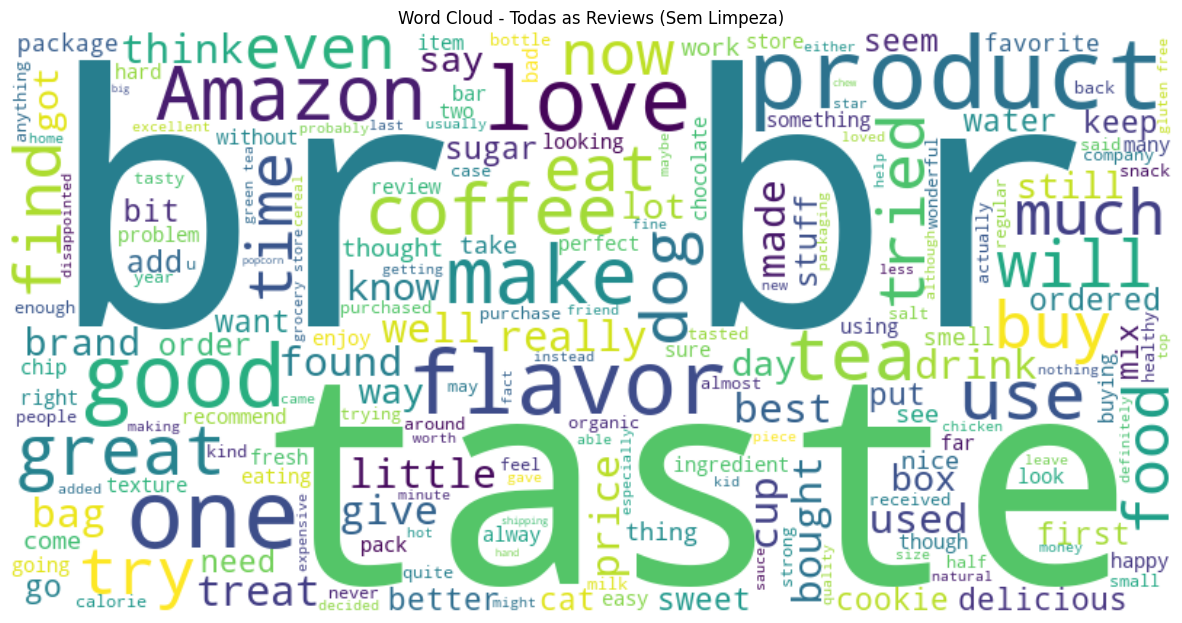

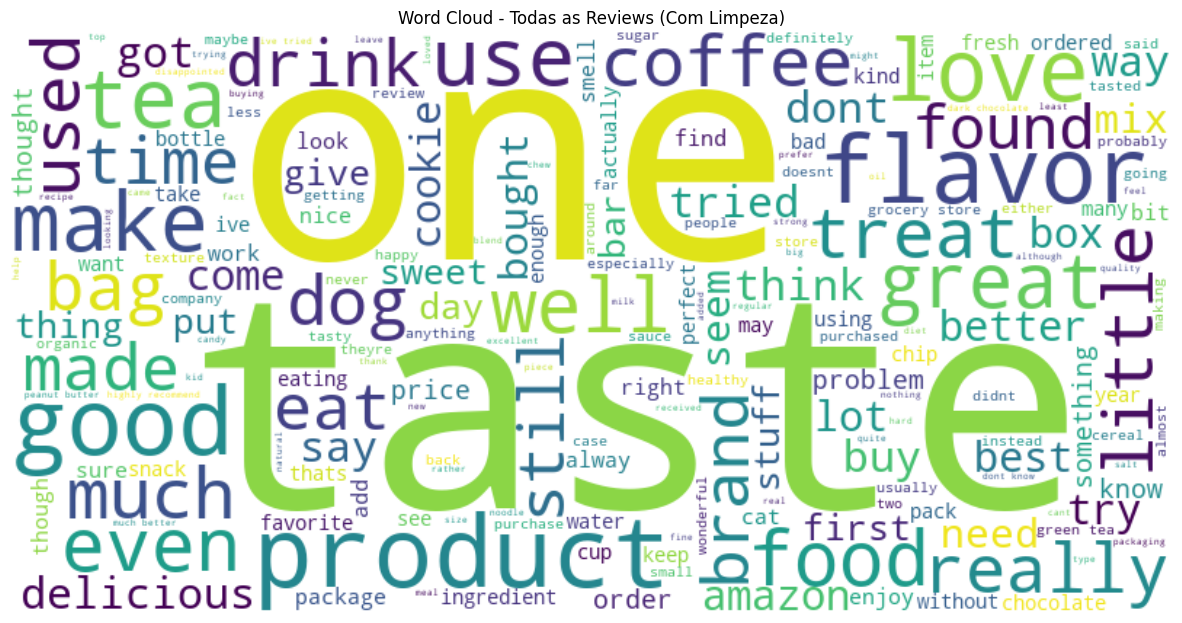

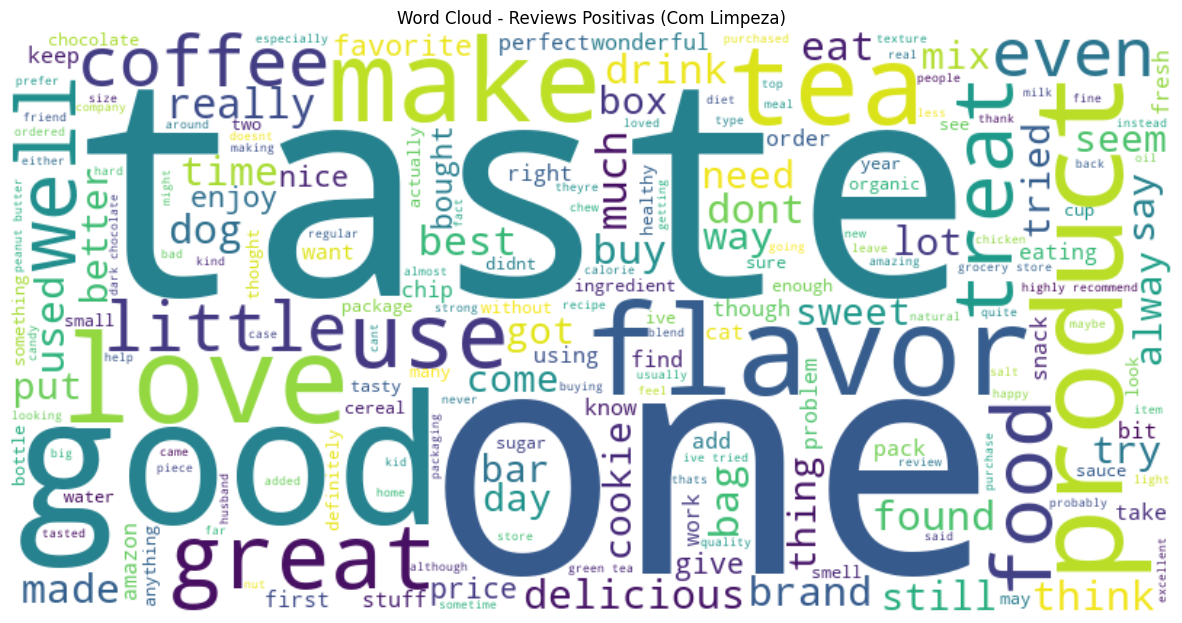

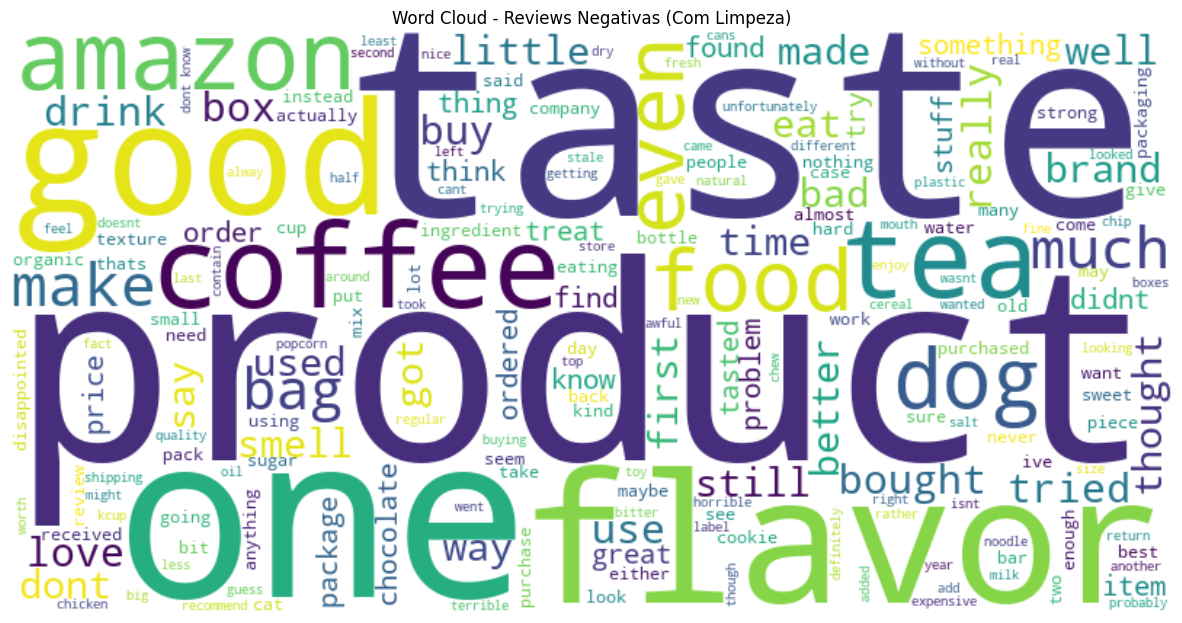

In [203]:
df = train_df.copy()
textos_originais = df['review'].astype(str)

# #Limpeza: Remover HTML, datas, pontuação e algumas stopwords
stop_words = set(stopwords.words('english'))
sentiment_words = {'no', 'not', 'never', 'don', 'doesn', 'isn', 'aren', 'wasn', 'weren', 'didn', 'couldn', 'shouldn', 'wouldn'}
custom_stopwords = stop_words - sentiment_words

tokenizer = TweetTokenizer()

def clean_text(text):
    # Remover tags HTML específicas
    text = text.replace('<br />', '\n')
    text = re.sub(r'<a[^>]*>', '', text)
    text = text.replace('</a>', '')
    text = re.sub(r'<span[^>]*>', '', text)
    text = text.replace('</span>', '')
    text = text.replace('<p>', '').replace('</p>', '')

    # Remover datas
    text = re.sub(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', ' ', text)
    text = re.sub(r'\b\d{4}[/-]\d{1,2}[/-]\d{1,2}\b', ' ', text)

    # Remover pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Converter para minúsculas
    text = text.lower()
    # Remover números
    text = re.sub(r'\d+', '', text)

    # Tokenizar
    tokens = tokenizer.tokenize(text)

    # Remover stopwords (exceto sentimentais) e palavras curtas
    tokens = [t for t in tokens if t not in custom_stopwords and len(t) > 2]

    return ' '.join(tokens)

# Aplicar limpeza
textos_limpos = textos_originais.apply(clean_text)

# Função para gerar Word Cloud
def gerar_wordcloud(textos, titulo):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(textos))
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {titulo}")
    plt.show()

# Análise sem limpeza (para todos os textos)
gerar_wordcloud(textos_originais, "Todas as Reviews (Sem Limpeza)")

# Análise com limpeza (para todos os textos)
gerar_wordcloud(textos_limpos, "Todas as Reviews (Com Limpeza)")

# Limpeza dos textos
df['review_clean'] = df['review'].astype(str).apply(clean_text)

# Filtrar por sentimento
textos_positivos = df[df['sentiment'] == 'positive']['review_clean']
textos_negativos = df[df['sentiment'] == 'negative']['review_clean']

# Word Cloud para as Reviews Positivas com limpeza
gerar_wordcloud(textos_positivos, "Reviews Positivas (Com Limpeza)")

# Word Cloud para as Reviews Negativas com limpeza
gerar_wordcloud(textos_negativos, "Reviews Negativas (Com Limpeza)")


TF;IDF;TF- --> Ver top 5 palavras com maior e menor valro em cada métrica

In [204]:
# Função para calcular IDF manualmente
def calcular_idf(corpus):
    total_documentos = len(corpus)
    idf_dict = {}
    for documento in corpus:
        for palavra in set(documento.split()):
            idf_dict[palavra] = idf_dict.get(palavra, 0) + 1
    for palavra, freq in idf_dict.items():
        idf_dict[palavra] = math.log10(total_documentos / freq)
    return idf_dict

# Função principal de análise
def analisar_textos(textos, titulo):
    print(f"\nAnálise para: {titulo}")

    # TF
    tokens = ' '.join(textos).split()
    contagem = Counter(tokens)
    tf_df = pd.DataFrame(contagem.items(), columns=['Palavra', 'Frequência']).sort_values(by='Frequência', ascending=False)
    print("\nTop 5 palavras com maior frequência (TF):")
    print(tf_df.head(5))
    print("\nTop 5 palavras com menor frequência (TF):")
    print(tf_df.tail(5))

    # IDF
    idf_valores = calcular_idf(textos)
    idf_df = pd.DataFrame(idf_valores.items(), columns=['Palavra', 'IDF']).sort_values(by='IDF', ascending=False)
    print("\nTop 5 palavras com maior valor IDF (mais raras):")
    print(idf_df.head(5))
    print("\nTop 5 palavras com menor valor IDF (mais comuns):")
    print(idf_df.tail(5))

    # TF-IDF
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_matrix = tfidf.fit_transform(textos)
    feature_names = tfidf.get_feature_names_out()
    df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    tfidf_avg = df_tfidf.mean().sort_values(ascending=False)

    print("\nTop 5 termos por TF-IDF médio (mais relevantes):")
    print(tfidf_avg.head(5))
    print("\nTop 5 termos por TF-IDF médio (menos relevantes):")
    print(tfidf_avg.tail(5))

# Exemplos:
analisar_textos(df['review_clean'], "Todas as Reviews")
analisar_textos(df[df['sentiment'] == 'positive']['review_clean'], "Reviews Positivas")
analisar_textos(df[df['sentiment'] == 'negative']['review_clean'], "Reviews Negativas")



Análise para: Todas as Reviews

Top 5 palavras com maior frequência (TF):
    Palavra  Frequência
11      not       27150
208    like       20375
65     good       15325
150   taste       14000
116     one       13090

Top 5 palavras com menor frequência (TF):
          Palavra  Frequência
28697  storefront           1
28696   illwilled           1
28695     pompous           1
28693     egnlish           1
49825      seince           1

Top 5 palavras com maior valor IDF (mais raras):
              Palavra       IDF
49825          seince  4.656769
37761  digestionlemon  4.656769
22660         bettern  4.656769
22659  disappointedpb  4.656769
22658     caloriesnot  4.656769

Top 5 palavras com menor valor IDF (mais comuns):
    Palavra       IDF
79    great  0.651846
137   taste  0.639235
58     good  0.580019
208    like  0.510517
11      not  0.411009

Top 5 termos por TF-IDF médio (mais relevantes):
not        0.089480
like       0.072252
good       0.065269
great      0.062521
pro

Verificar idiomas presentes

In [205]:
# Função para detetar idiomas
def detect_language(text):
    try:
        return detect(str(text))
    except LangDetectException:
        return "error"

# Configurar barra de progresso para operações longas
tqdm.pandas()

# Detectar idiomas no conjunto de treino
print("A detetar idiomas no treino...")
lang_distribution_train = train_df['review'].progress_apply(detect_language).value_counts()

# Detectar idiomas no conjunto de teste
print("A detetar idiomas no teste...")
lang_distribution_test = test_df['review'].progress_apply(detect_language).value_counts()

# Exibir resultados
print("\nDistribuição de idiomas no treino:")
print(lang_distribution_train)

print("\nDistribuição de idiomas no teste:")
print(lang_distribution_test)


A detetar idiomas no treino...


100%|██████████| 45370/45370 [01:57<00:00, 387.33it/s]


A detetar idiomas no teste...


100%|██████████| 2417/2417 [00:05<00:00, 425.45it/s]


Distribuição de idiomas no treino:
review
en    45351
de        6
es        5
no        2
pt        2
sq        1
et        1
af        1
fr        1
Name: count, dtype: int64

Distribuição de idiomas no teste:
review
en    2414
es       2
de       1
Name: count, dtype: int64


In [206]:
non_english_train = train_df[train_df['review'].progress_apply(detect_language) != 'en']
non_english_test = test_df[test_df['review'].progress_apply(detect_language) != 'en']

print("\nReviews não-inglesas no treino:")
print(non_english_train)

print("\nReviews não-inglesas no teste:")
print(non_english_test)

100%|██████████| 2417/2417 [00:05<00:00, 455.18it/s]


Reviews não-inglesas no treino:
      sentiment                                             review  \
2683   positive  Muy buen producto. por su tama&ntilde;o, uno l...   
6164   positive  Excellent tasting.  Will have to remember to o...   
7441   positive  I like the syrup.  What more can I say. I like...   
10230  positive  lite baconaise has great flavor does not tast ...   
13856  positive  Son excelentes, les encantan a mis perritos y ...   
19724  positive  BEST BREAD GLUTEN FREE SO FAR!!! EASY WITH BRE...   
23605  positive  Lo compr&eacute; como regalo para mi familia e...   
28435  positive  VERY GOOD SERVICE, FABULOUS PRODUCT, VERY FRES...   
34285  positive  MUY BUENA PRESENTACION, LA CAJA ES COMPACTA, P...   
34402  positive  THIS IS A GREAT PASTA. GOOD FOR USUAL SERVING,...   
35770  negative  I didn't like it - very strong smell - too str...   
36670  negative  Mi gato no le hace caso en lo mas minimo, se l...   
38053  positive  GREAT PRODUCT AND DELICIOUS GELATIN, THI

# Funções de Pré-processamento

Negation Handling

In [207]:
#O que acontece aqui:
#1. A função handle_negations_with_not recebe um texto e procura por palavras de negação.
#2. Se encontrar uma palavra de negação, ela marca a negação como ativa.
#3. Enquanto a negação estiver ativa, ela adiciona "NOT_" antes de cada token subsequente.
#4. Se encontrar um separador de negação (como pontuação ou conjunção), a negação é desativada.
#5. Ele junta os tokens processados em string e retorna o resultado.

def handle_negations_with_not(text):
    negation_words = {"not", "no", "never", "n't"}
    tokens = word_tokenize(text)
    processed_tokens = []
    negate = False

    for token in tokens:
        if token.lower() in negation_words:
            negate = True
            processed_tokens.append(token)
        elif negate:
            if token in {".", ",", "!", "?", ":", ";", "but","however","although","even though","despite","in spite of"}:
                negate = False
            processed_tokens.append(f"NOT_{token}" if negate else token)
        else:
            processed_tokens.append(token)

    return ' '.join(processed_tokens)

# Exemplo de uso da função handle_negations_with_not
text = "I do not like this movie, but I enjoyed the soundtrack."
result = handle_negations_with_not(text)
print(result)


I do not NOT_like NOT_this NOT_movie , but I enjoyed the soundtrack .


Apagar quebras de linha

In [208]:
def remove_newlines(text):
    text = re.sub(r'[\n\r]', '', text)
    return text
# Exemplo de uso da função remove_newlines
text = "Olá!\nTudo Bem?\rSim!"
result = remove_newlines(text)
print(result)


Olá!Tudo Bem?Sim!


Stemming(Porter) com a adição de reconverter os tokens em string

In [209]:
def apply_stemming(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

text = "I love learning new things every day."
result = apply_stemming(text)
print(result)

i love learn new thing everi day .


Correção ortográfica com SymSpell

In [210]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

def correct_spelling_symspell(text):
    corrected_text = []
    for word in text.split():
        suggestion = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected_text.append(suggestion[0].term if suggestion else word)
    return " ".join(corrected_text)


2025-04-26 18:23:54,901: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en_82_765.txt.


NER que reconverte para string 

In [211]:
# Função de NER usando processamento em batches para ser mais rápido
def named_entity_recognition_batch(reviews):
    entities_list = []
    for doc in nlp.pipe(reviews, batch_size=50):

        entities = " ".join([ent.text for ent in doc.ents])
        entities_list.append(entities)
    return entities_list
reviews = [
    "Apple is a technology company founded in Cupertino.",
    "I love going to New York City for vacation.",
    "Tesla was founded by Elon Musk in 2003."
]

# Aplicar a função NER
result = named_entity_recognition_batch(reviews)

# Exibir o resultado
print(result)

['Apple Cupertino', 'New York City', 'Elon Musk 2003']


Segmentaçao de frases

In [212]:
def sentence_segmentation(text):
    return sent_tokenize(text)

text = "Hello! How are you? I hope you're doing well. Have a great day ahead."

#Exemplo
sentences = sentence_segmentation(text)
print(sentences)

['Hello!', 'How are you?', "I hope you're doing well.", 'Have a great day ahead.']


Função para remover tags html(especificamente as encontradas)

In [213]:
# Função para remover tags HTML específicas
def remove_specific_html_tags(text):
    text = text.replace('<br />', '\n')
    text = re.sub(r'<a[^>]*>', '', text)
    text = re.sub(r'<span[^>]*>', '', text)
    text = text.replace('</span>', '')
    text = text.replace('<p>', '').replace('</p>', '')

    return text

# Exemplo de texto com tags HTML
text = "<p>I love <span>learning</span> new things <br />every day.</p>"
result = remove_specific_html_tags(text)
print(result)



I love learning new things 
every day.


Remover outros caracteres estranhos

In [214]:
padrao = re.compile(r"[^a-zA-Z0-9\s.,;:!?\"'()\[\]{}@#%&/\-_=+<>€$£]")

def remover_caracteres_estranhos(text):
    return padrao.sub('', str(text))

# Exemplo de texto com caracteres estranhos
text = "I love learning new things! ~~^"
result = remover_caracteres_estranhos(text)

# Exibindo o resultado
print(result)


I love learning new things! 


Remover espaços duplos

In [215]:
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()
text = "I    love    learning   new  things!"
result = remove_multiple_spaces(text)
print(result)


I love learning new things!


Case folding

In [216]:
def case_folding(text):

    return text.lower()
text = "I LoVe LeaRning NeW tHinGs!"
result = case_folding(text)
print(result)

i love learning new things!


Case folding mantendo as palavras em caps lock


In [217]:
def case_folding_with_caps_lock(text):

    words = text.split(" ")
    processed_words = [word if word.isupper() else word.lower() for word in words]
    return " ".join(processed_words)


text = "EU adoro ANÁLISE de Miau SENTIMENTOS e PLN !"
result = case_folding_with_caps_lock(text)
print(result)

EU adoro ANÁLISE de miau SENTIMENTOS e PLN !


Expandir contrações 

In [218]:
def expand_contractions(text):
    return contractions.fix(text)

text = "I'm learning new things and I can't wait to see the results!"
result = expand_contractions(text)
print(result)


I am learning new things and I cannot wait to see the results!


Converter alguns emojis em texto 

In [219]:
def replace_emojis(text):

    emoji_dict = {
        ':)': 'good',
        ':-)': 'good',
        ':-D': 'good',
        ':D': 'good',
        ':(': 'bad',
        ':-(': 'bad',
        ':O': 'surprised',
    }

    for emoji, emotion in emoji_dict.items():
        text = text.replace(emoji, emotion)

    return text

text = "I am so happy today! :) It's a great day :-D but I'm also a bit tired :("
result = replace_emojis(text)
print(result)


I am so happy today! good It's a great day good but I'm also a bit tired bad


Remover datas 

In [220]:
def remove_dates(text):

    text = re.sub(r'\b\d{1,4}[-/]\d{1,2}[-/]\d{1,4}\b', '', text)
    text = re.sub(r'\b\d{4}\b', '', text)
    return text.strip()

text = "My birthday is on 05-12-2025 and the event will be in 2026."
result = remove_dates(text)
print(result)


My birthday is on  and the event will be in .


Remover números

In [221]:
def remove_numbers(text):

    text = re.sub(r'\b\d+\.\d+\b', '', text)
    text = re.sub(r'\b\d+\b', '', text)
    return text.strip()
text = "I have 3 apples, 12.5 oranges, and 10 bananas."
result = remove_numbers(text)
print(result)


I have  apples,  oranges, and  bananas.


Remover algumas stopwords

In [222]:
# Lista personalizada de stopwords para manter as importantes para sentimento
custom_stopwords = set(stopwords.words('english')) - {
    "not", "no", "nor", "never", "n't", "but", "very", "just", "only", "so", "too",
    "aren't", "couldn't", "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't",
    "isn't", "mightn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't",
    "weren't", "won't", "wouldn't", 
}

def remove_stopwords(text):

    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in custom_stopwords]
    return ' '.join(filtered_tokens)

text = "I don't like this movie, but the soundtrack is amazing!"
result = remove_stopwords(text)
print(result)


n't like movie , but soundtrack amazing !


Remover pontuação 

In [223]:
def remove_punctuation(text):
    punctuation_to_remove = set(string.punctuation) - {"!", "?"}
    return ''.join([char for char in text if char not in punctuation_to_remove])

text = "Hello! How are you doing today? I'm good, thanks."
result = remove_punctuation(text)
print(result)


Hello! How are you doing today? Im good thanks


Pos tagging --> aceita texto retorna lista de tuples

In [224]:
def pos_tagging(text):

    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return pos_tags

text = "The quick brown fox jumps over the lazy dog."
result = pos_tagging(text)
print(result)


[('The', 'DT'), ('quick', 'JJ'), ('brown', 'NN'), ('fox', 'NN'), ('jumps', 'VBZ'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.')]


Lematização 

In [225]:
def lemmatize_text(text):
    doc = nlp(text)
  
    lemmatized = [token.lemma_ for token in doc if token.is_alpha]
    return ' '.join(lemmatized)
text = "The children are playing in the park."
result = lemmatize_text(text)
print(result)


the child be play in the park


Várias funções de Tokenização

In [226]:
#SPACE BASED TOKENIZATION
def space_based_tokenization(text):
    return text.split(" ")

#   WORDPIECE TOKENIZATION -- BOM PARA BERT

wordpiece_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def wordpiece_tokenization(text):
    return wordpiece_tokenizer.tokenize(text)

#  WORD BASED TIPICA
def word_based_tokenization(text):
    return word_tokenize(text)


#Tokenização Subword BPE- bom para  modelos simples

def train_bpe_tokenizer(texts):
    tokenizer = Tokenizer(models.BPE())
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

    trainer = trainers.BpeTrainer(vocab_size=5000, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
    tokenizer.train_from_iterator(texts, trainer)

    return tokenizer
corpus = [text]
bpe_tokenizer = train_bpe_tokenizer(corpus)
#exemplos
text = "I love learning new things, especially data science!"
result = space_based_tokenization(text)
print(result)
result = wordpiece_tokenization(text)
print(result)
result = word_based_tokenization(text)
print(result)
encoded = bpe_tokenizer.encode(text)
print(encoded.tokens)


['I', 'love', 'learning', 'new', 'things,', 'especially', 'data', 'science!']
['i', 'love', 'learning', 'new', 'things', ',', 'especially', 'data', 'science', '!']
['I', 'love', 'learning', 'new', 'things', ',', 'especially', 'data', 'science', '!']
['l', 'e', 'l', 'e', 'ar', 'n', 'ing', 'n', 'e', 't', 'h', 'ing', 'e', 'p', 'e', 'c', 'i', 'a', 'l', 'l', 'y', 'd', 'a', 't', 'a', 'c', 'i', 'en', 'c', 'e']


In [227]:
#Traduzir as reviews não-inglesas para inglês
translator = Translator()
# Função para traduzir texto para inglês
def translate_to_english(text, src_lang):
    if src_lang == 'en' or src_lang == 'error':
        return text  # Não traduzir se já for inglês ou erro na deteção
    try:
        translation = translator.translate(text, src=src_lang, dest='en')
        return translation.text
    except Exception as e:
        print(f"Erro ao traduzir: {e}")
        return text  # Se falhar, devolve o texto original


In [228]:
# Primeiro, detetar novamente as línguas e guardar numa coluna
train_df['lang'] = train_df['review'].progress_apply(detect_language)
test_df['lang'] = test_df['review'].progress_apply(detect_language)

# Traduz apenas as reviews não-inglesas
# Aplicar a função de tradução para os conjuntos de treino e teste
train_df['review_translated'] = train_df.apply(
    lambda row: translate_to_english(row['review'], row['lang']), axis=1
)
test_df['review_translated'] = test_df.apply(
    lambda row: translate_to_english(row['review'], row['lang']), axis=1
)

100%|██████████| 2417/2417 [00:05<00:00, 404.86it/s]


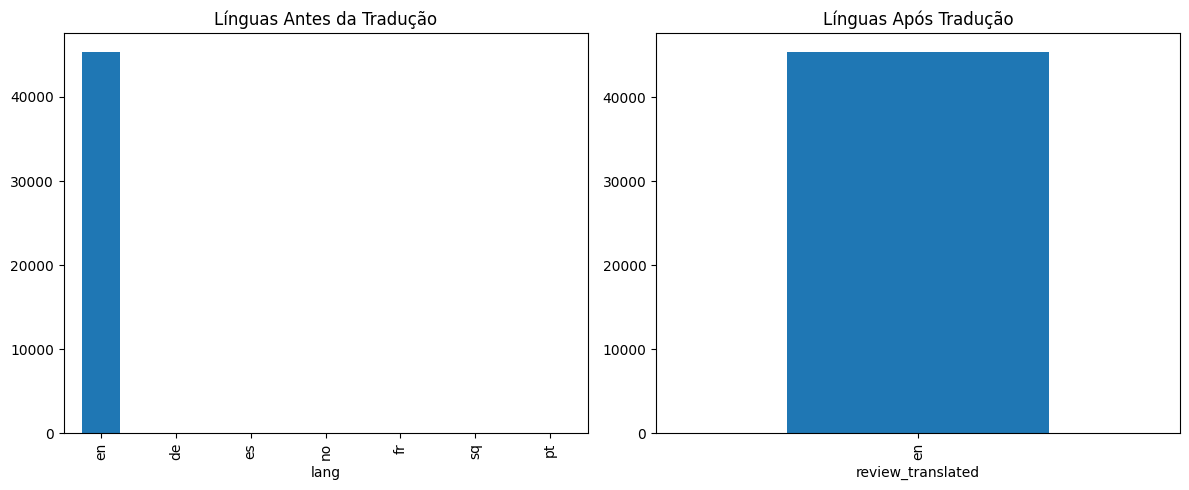

In [229]:
# Antes da tradução
lang_counts_before = train_df['lang'].value_counts()

# Depois da tradução
lang_counts_after = train_df['review_translated'].apply(
    lambda x: 'en' if x else 'other'
).value_counts()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

lang_counts_before.plot(kind='bar', ax=ax[0], title='Línguas Antes da Tradução')
lang_counts_after.plot(kind='bar', ax=ax[1], title='Línguas Após Tradução')

plt.tight_layout()
plt.show()


Aplicar pré-processamentos ao dataset

In [230]:
#Fazer upload outra vez para ter a certeza que está limpinho e não afetado pelas demonstrações anteriores
treino = pd.read_csv('amazon_reviews_train.csv')
teste = pd.read_csv('amazon_reviews_test.csv')

""" remove_stopwords(text)
remove_punctuation(text)
remove_specific_html_tags(text)
remove_multiple_spaces(text)
expand_contractions(text)
replace_emojis(text)
remove_dates(text)
remove_numbers(text)
space_based_tokenization(text)
word_based_tokenization(text)
case_folding_with_caps_lock(text)
case_folding(text)
pos_tagging(text)
lemmatize_text(text)
handle_negations_with_not(text)
remove_newlines(text)
apply_stemming(text)
correct_spelling_symspell(text)
sentence_segmentation(text)
named_entity_recognition_batch(text)
remover_caracteres_estranhos(text) """


#Aplicar as funções de pré-processamento por ordem
def preprocess_text(text):
    text = remove_specific_html_tags(text)
    text = replace_emojis(text)
    text = remover_caracteres_estranhos(text)
    text = remove_multiple_spaces(text)
    text = handle_negations_with_not(text)
    text = apply_stemming(text)
    return text

train_df['review'] = train_df['review'].apply(preprocess_text)
test_df['review'] = test_df['review'].apply(preprocess_text)

train_df.to_csv('amazon_reviews_train_processed.csv', index=False)
test_df.to_csv('amazon_reviews_test_processed.csv', index=False)
